In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import glob
import os, os.path
import matplotlib.patches as  mpatches
import matplotlib.lines as mlines
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import pearsonr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('../')
from models import configs, engine
from utils import utils, dataloader, RWSampler

In [4]:
label_dir = '/data2/hkaman/Livingston/data/10m/new_labels/*.npy'
label_names = sorted(glob.glob(label_dir))
img_dir = '/data2/hkaman/Livingston/data/10m/new_imgs/*.npy'
img_names = sorted(glob.glob(img_dir))

In [5]:
len(label_names)

205

In [6]:
MIN_EXTREME_VALUE_Threshold = 22.24
Max_EXTREME_VALUE_Threshold = 54.36

HECTARE_TO_ACRE_SCALE = 2.471 # 2.2417

In [8]:
class hist_dist_plot():
    def __init__(self, label_dir):
        self.label_dir = label_dir
    
    def _return_pair_dict(self,):

        # label_names = sorted(glob.glob(self.label_dir))
        pair_dict = {}
        all_label_mtx = []

        for idx, name in enumerate(label_names):

            block_name = name[-22:-10]
            # print(block_name[:-5])
            mtx_raw = np.load(name, allow_pickle=True)
            img_raw = np.load(img_names[idx], allow_pickle=True)
            mtx = mtx_raw.flatten()
            mtx[mtx < 0]  = -1

            res = {key: configs.blocks_information[key] for key in configs.blocks_information.keys() & {block_name[:-5]}}
            list_d = res.get(block_name[:-5])

            block_variety = list_d[0]

            all_label_mtx.append(mtx)


            _d = {'label' : mtx, 
                  'mtx' : mtx_raw,
                  'img_mtx': img_raw,
                  'block' : block_name,
                  'cultivar': block_variety}
            pair_dict[block_name] = _d

        all_label_mtx = np.concatenate(all_label_mtx)
        all_label_mtx = all_label_mtx[all_label_mtx >= 0]
        all_label_mtx = all_label_mtx * HECTARE_TO_ACRE_SCALE

        return pair_dict, all_label_mtx
    



    def _plot_hist_dsit(self):

        pair_dict, all_label_mtx = self._return_pair_dict()
        # calculating the count for historgram plot: 
        df = pd.DataFrame()
        df['ytrue'] = all_label_mtx

        counts = []
        for i in range(1, 75):
            if i == 1:
                Data  = df.loc[(df['ytrue'] < (i+1))]
            elif i == 74: 
                Data  = df.loc[(df['ytrue'] >= (i))]
            else: 
                Data  = df.loc[(df['ytrue'] >= i) & (df['ytrue'] < (i+1))] 
            counts.append(len(Data))

        #print(f"{all_label_mtx.min()} |{all_label_mtx.mean()} | {all_label_mtx.max()}")

        fig, axs = plt.subplots(1, 1 , figsize = (12, 6))
        sns.set_style("whitegrid", {'axes.grid' : False})
        #plt.rcParams["figure.autolayout"] = True
        plt.subplots_adjust(hspace = 0.1)

        bins_value  = np.arange(1, 75, 1)
        sns.barplot(x = bins_value, y= counts, color = 'blue', ax = axs,) #
        for bar in (axs.patches):
            bar.set_width(1)
        

        axs.axvline(x = 15.6, linestyle = '--', color = 'g', label = 'Lower Control Point of Extreme Values')
        axs.axvline(x = 29.5, color = 'k', label = 'Mean Value')
        axs.axvline(x = 50, linestyle = '--', color = 'g', label = 'Upper Control Point of Extreme values')



        axs01 = axs.twinx()
        for k, v in pair_dict.items():
            label_mtx = v['label']
            label_mtx = label_mtx[label_mtx >= 0]
            label_mtx = label_mtx * HECTARE_TO_ACRE_SCALE

            if (label_mtx.mean() < 15) or (label_mtx.mean() > 50):
                ax = sns.kdeplot(label_mtx, ax = axs01, color ='red', shade ='fill', alpha=.1, legend=True,)
            else: 
                ax = sns.kdeplot(label_mtx, ax = axs01, color ='grey', alpha=.2, legend=True,)

        handles = [mpatches.Patch(facecolor = 'blue', label = 'Pixel Count Per Bin'),
        mpatches.Patch(facecolor = 'grey', label = 'Distribution of Blocks'),
        mpatches.Patch(facecolor = 'red', label = 'Distribution of Blocks within EVR'),
        mlines.Line2D([], [], linestyle='--', linewidth=2, color='green', label = 'CPs of Extreme values'),
        mlines.Line2D([], [], linewidth=2, color='k', label = 'Mean Value'),
        ] 
        
        axs.legend(handles = handles, loc = 'upper right', fontsize=10)
        axs.set_ylabel('Number of Pixels', fontsize=13)
        axs01.set_ylabel(ylabel='Density', fontsize=13)
        axs.set_xlabel('Yield Value (t/ha)', fontsize=13)
        axs.set_xlim(- 1, 75)

        # axs.set_xticklabels(bins_value)
        # plt.xticks(np.arange(0, 75, 1), fontsize=10)
        # Set x-tick positions and labels
        axs.set_xticks(np.arange(0, 76, 5))  # Set ticks at positions divisible by 5
        axs.set_xticklabels(np.arange(0, 76, 5), fontsize=10)  # Set tick labels to the same values

        fig.tight_layout()

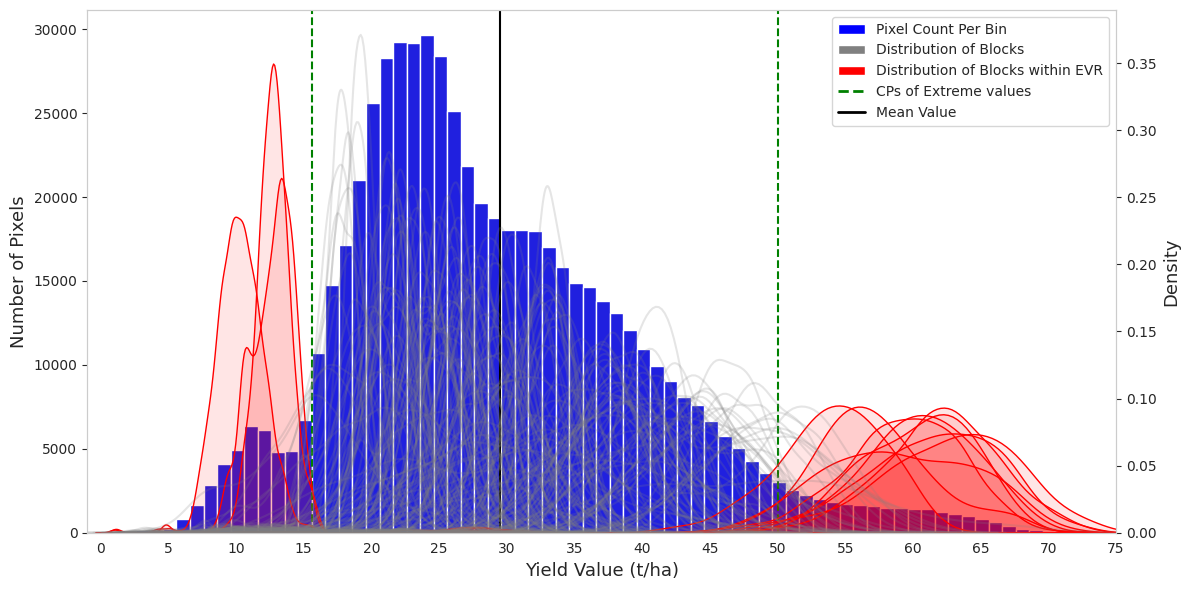

In [34]:
_ = hist_dist_plot(label_dir)._return_pair_dict()

### YieldZone

In [9]:
pair_dict, all_label_mtx = hist_dist_plot(label_dir)._return_pair_dict()

In [10]:
liv_105_2018_label = pair_dict['LIV_105_2018']['mtx']
liv_105_2018_img = pair_dict['LIV_105_2018']['img_mtx']

In [11]:
liv_105_2018_img.shape

(15, 67, 79, 4)

In [70]:
def return_yield_zone_3_class(mask):
    # Initialize an empty array with the same shape as the image for the segmented output
    segmented = np.zeros_like(mask)
    segmented[mask < 0] = -1
    # Class 1: Pixel values <= 9
    segmented[(mask >= 0) & (mask < 8)] = 1
    # Class 2: Pixel values > 9 and < 22
    segmented[(mask >= 8) & (mask < 22)] = 2
    # Class 3: Pixel values >= 22
    segmented[mask >= 22] = 3

    return segmented

def return_yield_zone_9_classes(mask):
    # Initialize an empty array with the same shape as the image for the segmented output
    segmented = np.zeros_like(mask)
    segmented[mask < 0] = -1

    # Values < 8: Class 1
    segmented[(mask >= 0) & (mask < 8)] = 1
    
    # Values between 8 and 22: Classes 2 to 8 (7 intervals of 2)
    for i, val in enumerate(range(8, 22, 2), start=2):
        lower_bound = val
        upper_bound = val + 2
        segmented[(mask >= lower_bound) & (mask < upper_bound)] = i
    
    # Values > 22 and < 30: Last class (9)
    segmented[(mask >= 22) & (mask < 30)] = 9
    
    # Value == 30: Also last class (9)
    segmented[mask == 30] = 9

    return segmented

def return_yield_zone_15_classes(mask):
    # Initialize an empty array with the same shape as the image for the segmented output
    segmented = np.zeros_like(mask)
    segmented[mask < 0] = -1

    
    for i in range(15):
        lower_bound = i * 2
        upper_bound = (i + 1) * 2
        segmented[(mask >= lower_bound) & (mask < upper_bound)] = i + 1
    
    # Special case for the upper boundary of the last class to include the value 30
    segmented[mask == 30] = 15

    return segmented

In [71]:
yz_3classes = return_yield_zone_3_class(liv_105_2018_label)
yz_9classes = return_yield_zone_9_classes(liv_105_2018_label)
yz_15classes = return_yield_zone_15_classes(liv_105_2018_label)

In [72]:
img_sample = liv_105_2018_img[14, :, :, :]/255.
mult_img = img_sample * yz_3classes[0, ...]
mult_img.shape

(67, 79, 4)

In [94]:
label = liv_105_2018_label[0, :, :, 0]
print(label[(label >= 22) & (label <= 30)].shape)

(499,)


In [96]:
print(yz_9classes[np.where(yz_9classes == 9)].shape)

(499,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Observation')

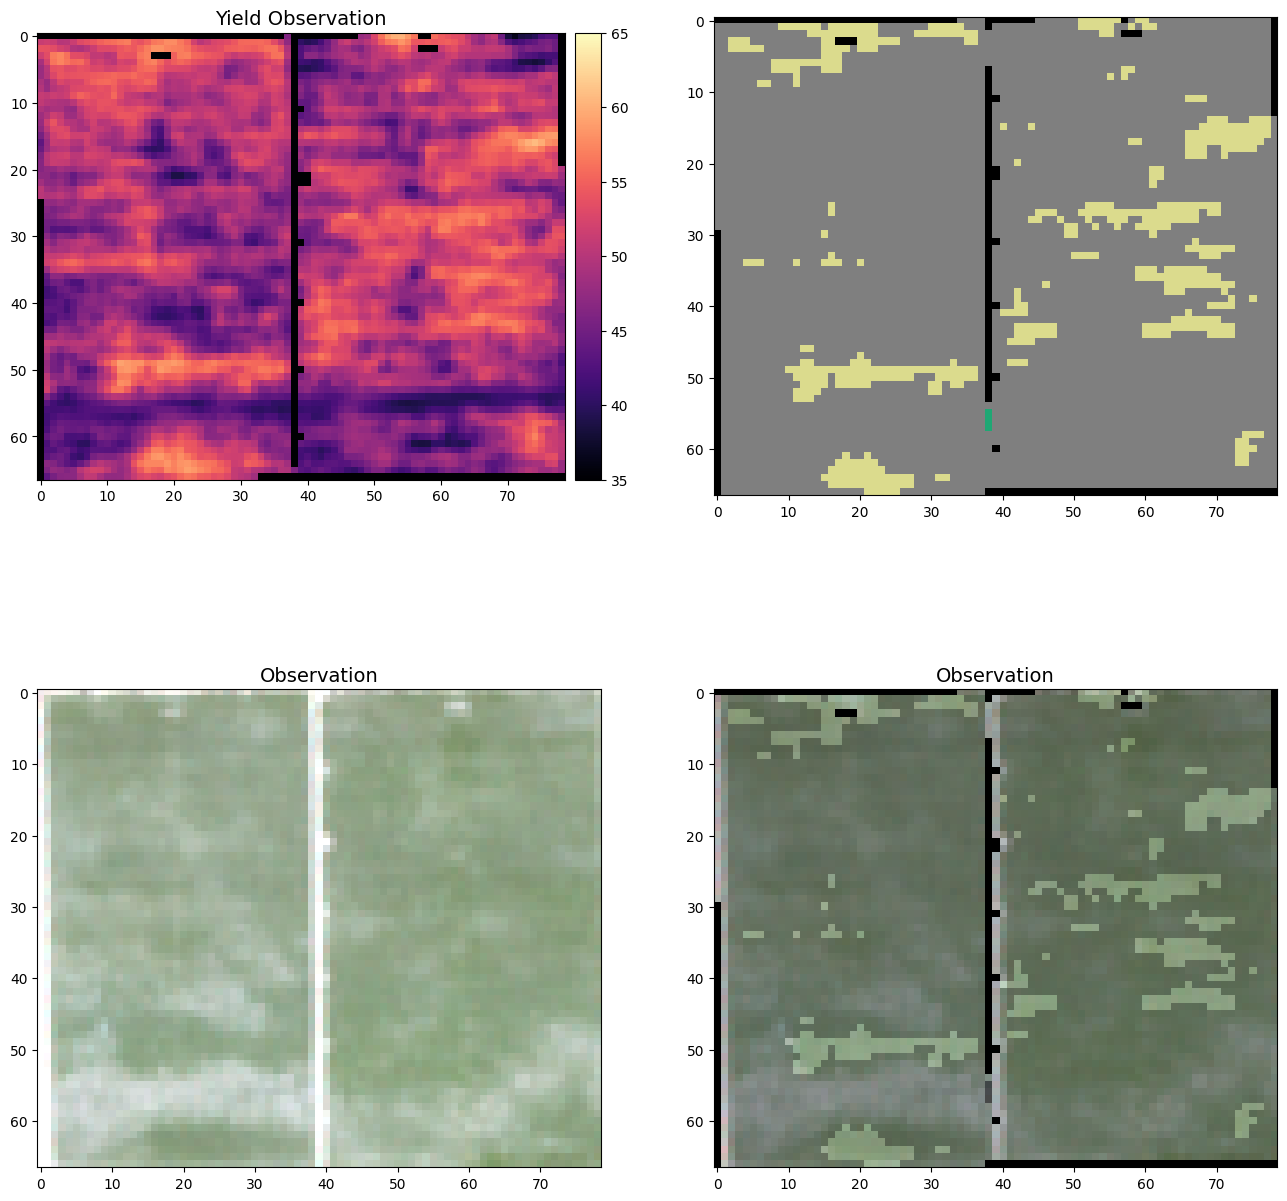

In [74]:
plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(2, 2, figsize = (16, 16))
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for i in range(num_years):
img1 = axs[0, 0].imshow(liv_105_2018_label[0, :, :, 0]*HECTARE_TO_ACRE_SCALE, cmap = 'magma')
axs[0, 0].set_title('Yield Observation', fontsize = 14)
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar1 = fig.colorbar(img1,  cax=cax)
img1.set_clim(35, 65)

import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['black',  # background
          '#1fa774', '#7f7f7f', '#dbdb8d',])
bounds = [-1, 0.5, 1.5, 2.5, 3.5]  # boundaries for each class
norm = mcolors.BoundaryNorm(bounds, cmap.N)
axs[0, 1].imshow(yz_3classes[0, :, :, 0], cmap=cmap, norm=norm, interpolation='nearest') # 

img2 = axs[1, 0].imshow(liv_105_2018_img[14, :, :, :]/255.)
axs[1, 0].set_title('Observation', fontsize = 14)

img3 = axs[1, 1].imshow(mult_img[:, :, 0:3]/3.)
axs[1, 1].set_title('Observation', fontsize = 14)

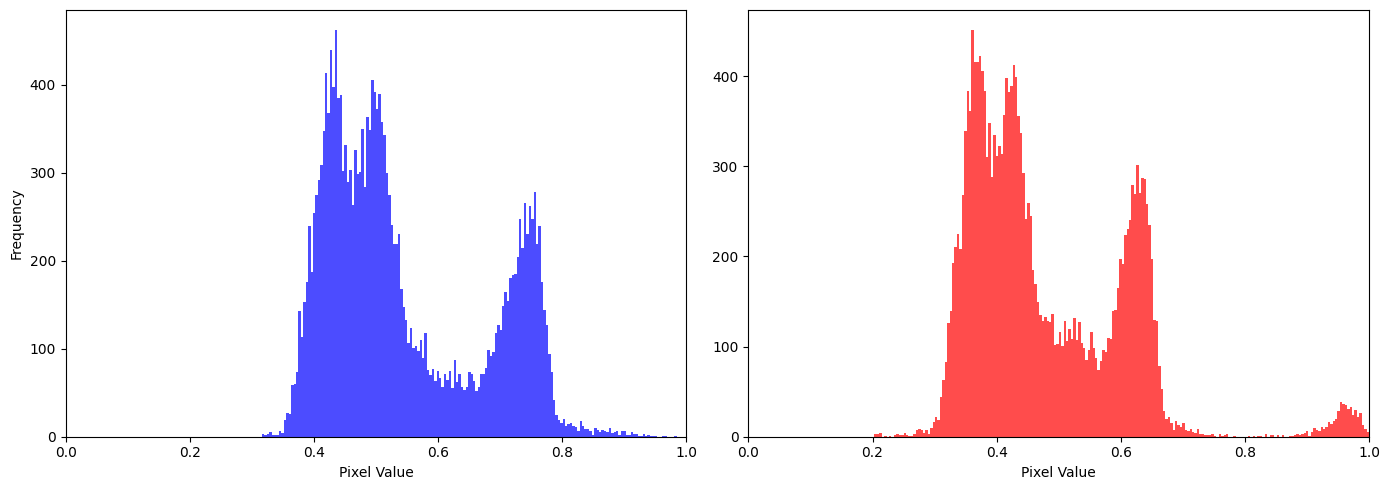

In [19]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Flatten the images if they are 2D and plot histograms
axs[0].hist(img_sample.flatten()/1.28, bins=256, range=[0, 1], color='blue', alpha=0.7)
# axs[0].set_title('Histogram for Image 1')
axs[0].set_xlim([0, 1])  # Assuming 8-bit images
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(mult_img.flatten()/3.02, bins=256, range=[0, 1], color='red', alpha=0.7)
# axs[1].set_title('Histogram for Image 2')
axs[1].set_xlim([0, 1])  # Assuming 8-bit images
axs[1].set_xlabel('Pixel Value')
# axs[1].set_ylabel('Frequency')  # Optional, as it's the same as the left plot

# Tight layout often improves the spacing between subplots
plt.tight_layout()
plt.show()

#### 11 Classes

In [62]:
mult_img_9 = img_sample * yz_9classes[0, ...]
mult_img_9.shape

(67, 79, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Observation')

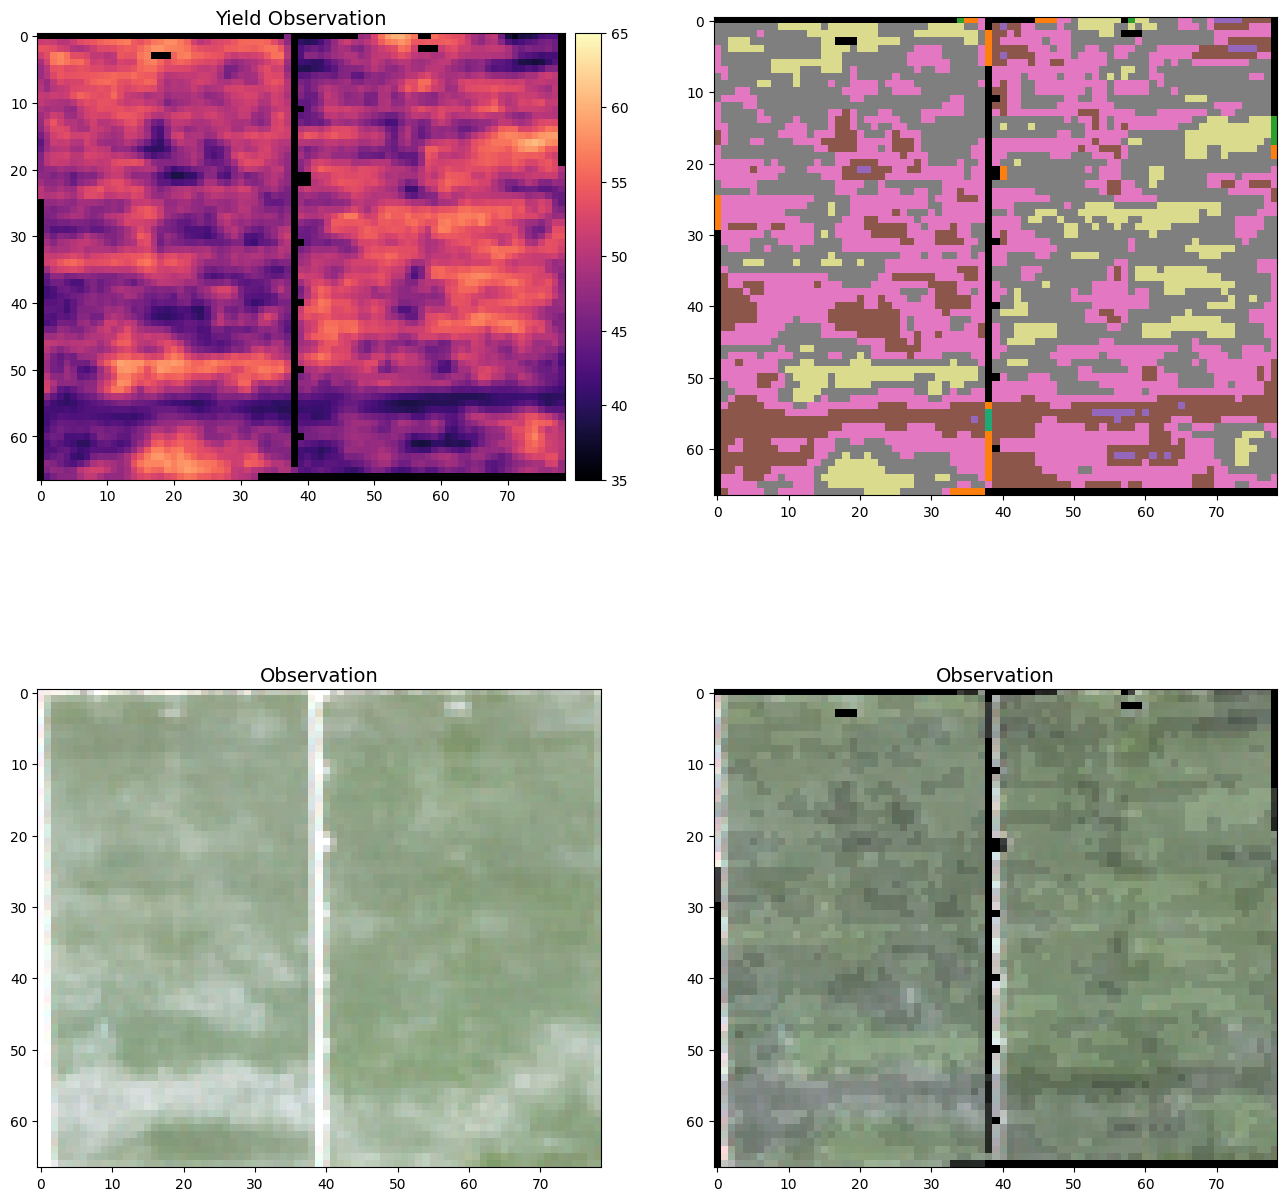

In [100]:
plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(2, 2, figsize = (16, 16))
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for i in range(num_years):
img1 = axs[0, 0].imshow(liv_105_2018_label[0, :, :, 0]*HECTARE_TO_ACRE_SCALE, cmap = 'magma')
axs[0, 0].set_title('Yield Observation', fontsize = 14)
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar1 = fig.colorbar(img1,  cax=cax)
img1.set_clim(35, 65)

# import matplotlib.colors as mcolors
colors = ['black',  # background
          '#1fa774', 
          '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
          '#dbdb8d']  

cmap = mcolors.ListedColormap(colors)
# bounds = list(range(-1, 10))  
bounds = [-1, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5 , 6.5, 7.5, 8.5, 9.5,]
norm = mcolors.BoundaryNorm(bounds, cmap.N)


axs[0, 1].imshow(yz_9classes[0, :, :, 0], 
                 cmap = cmap, 
                 norm = norm, 
                 ) # interpolation = 'nearest'

img2 = axs[1, 0].imshow(liv_105_2018_img[14, :, :, :]/255.)
axs[1, 0].set_title('Observation', fontsize = 14)

img3 = axs[1, 1].imshow(mult_img_9[:, :, 0:3]/9.0)
axs[1, 1].set_title('Observation', fontsize = 14)

In [99]:
bounds

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

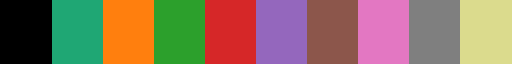

In [98]:
cmap

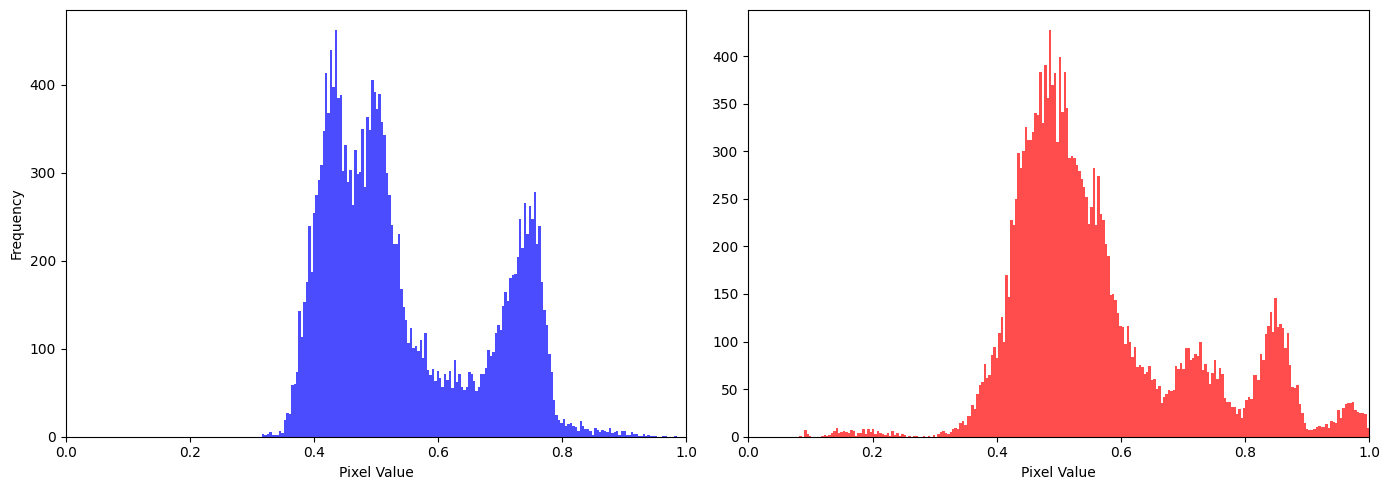

In [64]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Flatten the images if they are 2D and plot histograms
axs[0].hist(img_sample.flatten()/1.28, bins=256, range=[0, 1], color='blue', alpha=0.7)
# axs[0].set_title('Histogram for Image 1')
axs[0].set_xlim([0, 1])  # Assuming 8-bit images
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(mult_img_9.flatten()/9.0, bins=256, range=[0, 1], color='red', alpha=0.7)
# axs[1].set_title('Histogram for Image 2')
axs[1].set_xlim([0, 1])  # Assuming 8-bit images
axs[1].set_xlabel('Pixel Value')
# axs[1].set_ylabel('Frequency')  # Optional, as it's the same as the left plot

# Tight layout often improves the spacing between subplots
plt.tight_layout()
plt.show()

#### 15 classes

In [65]:
mult_img_15 = img_sample * yz_15classes[0, ...]
np.unique(mult_img_15)

array([-1.2558393, -1.2362933, -1.2108833, ..., 12.688889 , 12.831746 ,
       12.890678 ], dtype=float32)

In [66]:
np.unique(yz_15classes)

array([-1.,  4.,  5.,  6.,  8.,  9., 10., 11., 12., 13.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Observation')

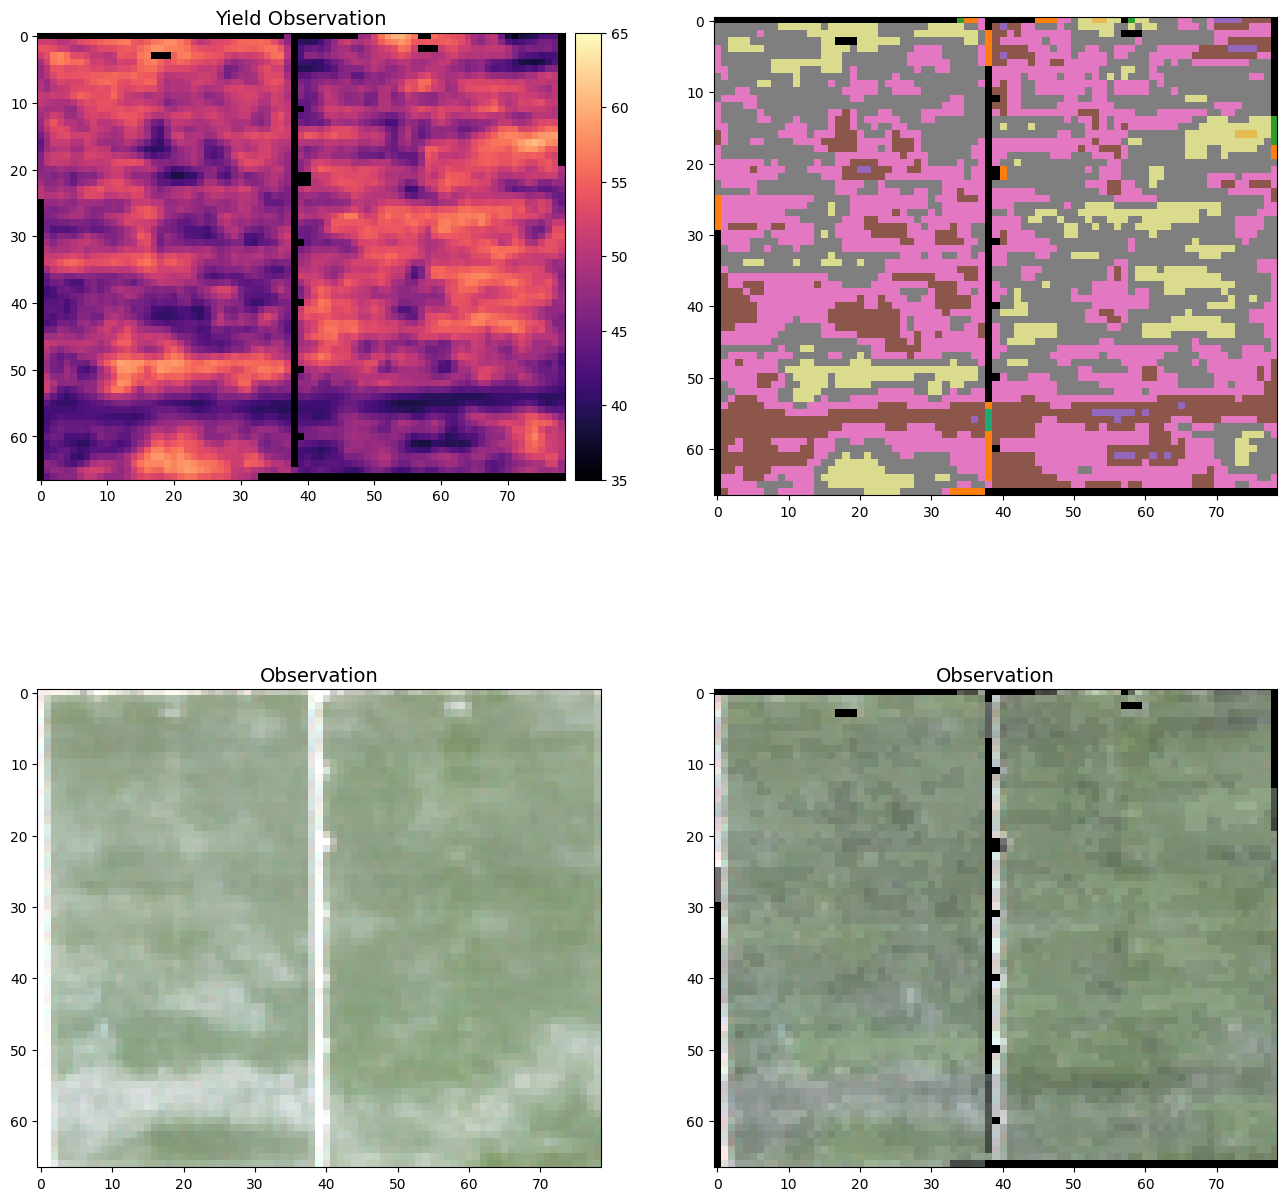

In [102]:
plt.rcParams["axes.grid"] = False
fig, axs = plt.subplots(2, 2, figsize = (16, 16))
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for i in range(num_years):
img1 = axs[0, 0].imshow(liv_105_2018_label[0, :, :, 0]*HECTARE_TO_ACRE_SCALE, cmap = 'magma')
axs[0, 0].set_title('Yield Observation', fontsize = 14)
divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar1 = fig.colorbar(img1,  cax=cax)
img1.set_clim(35, 65)


colors = ['black',  # background
          '#1f77b4', '#bcbd22', '#17becf', '#1fa774',
          '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
           '#dbdb8d', '#e7ba52', '#9edae5', '#aec7e8']  

cmap = mcolors.ListedColormap(colors)
# bounds = list(range(-1, 16))  # -1 for background, 0-15 for classes
bounds = [-1, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5 , 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

axs[0, 1].imshow(yz_15classes[0, :, :, 0], 
                 cmap = cmap, 
                 norm = norm, 
                 interpolation = 'nearest') # 

img2 = axs[1, 0].imshow(liv_105_2018_img[14, :, :, :]/255.)
axs[1, 0].set_title('Observation', fontsize = 14)

img3 = axs[1, 1].imshow(mult_img_15[:, :, 0:3]/12.0)
axs[1, 1].set_title('Observation', fontsize = 14)

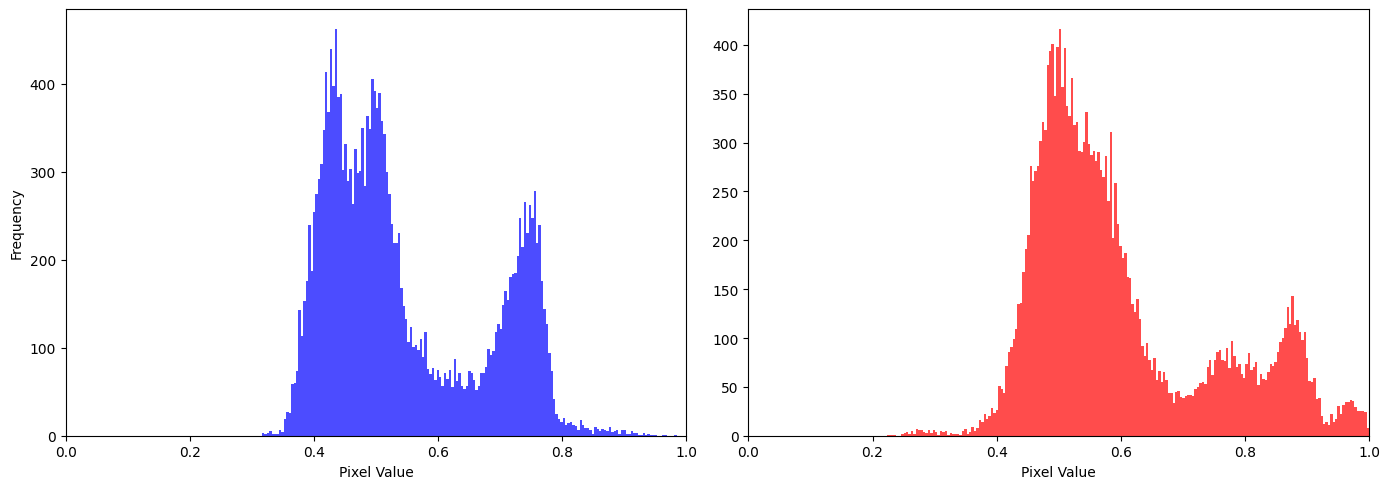

In [56]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Flatten the images if they are 2D and plot histograms
axs[0].hist(img_sample.flatten()/1.28, bins=256, range=[0, 1], color='blue', alpha=0.7)
# axs[0].set_title('Histogram for Image 1')
axs[0].set_xlim([0, 1])  # Assuming 8-bit images
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(mult_img_15.flatten()/12.0, bins=256, range=[0, 1], color='red', alpha=0.7)
# axs[1].set_title('Histogram for Image 2')
axs[1].set_xlim([0, 1])  # Assuming 8-bit images
axs[1].set_xlabel('Pixel Value')
# axs[1].set_ylabel('Frequency')  # Optional, as it's the same as the left plot

# Tight layout often improves the spacing between subplots
plt.tight_layout()
plt.show()

### Effetctive Distribution